<h1> Object Detection using YOLOV3 </h1>

**First start importing necessary libraries**



In [ ]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

albumentations==1.2.1 is successfully installed


In [ ]:
!pip install --upgrade --force-reinstall --no-deps albumentations
!pip install opencv-python-headless==4.5.5.62

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 116 kB 8.4 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47.7 MB 1.2 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.6.0.66
    Uninstalling opencv-python-headless-4.6.0.66:
      Successfully uninstalled opencv-python-headless-4.6.0.66


In [ ]:
import albumentations
albumentations.__version__

'1.2.1'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import random
import torch
import pandas as pd

from collections import Counter
from torch.utils.data import DataLoader
from tqdm import tqdm


In [ ]:
import albumentations as A
import cv2
import torch
import torch.nn as nn

from albumentations.pytorch import ToTensorV2

In [ ]:
DATASET = 'PASCAL_VOC'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 4
BATCH_SIZE = 32
IMAGE_SIZE = 416
NUM_CLASSES = 20
LEARNING_RATE = 3e-4 
WEIGHT_DECAY = 0 
NUM_EPOCHS = 20
CONF_THRESHOLD = 0.4 
MAP_IOU_THRESH = 0.5
NMS_IOU_THRESH = 0.45
S = [IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8]
PIN_MEMORY = True
LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_FILE = "checkpoint.pth.tar"
IMG_DIR = '/content/drive/MyDrive/pascalvoc/images'
LABEL_DIR = '/content/drive/MyDrive/pascalvoc/labels'

ANCHORS = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
]  # Note these have been rescaled to be between [0, 1]

PASCAL_CLASSES = [
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor"
]

**The below cell contains configuration for the entire network**

In [ ]:
config = [
    (32,3,1),
    (64,3,2),
    ["B",1],
    (128,3,2),
    ["B",2],
    (256,3,2),
    ["B",8],
    (512,3,2),
    ["B",8],
    (1024,3,2),
    ["B",4], #Upto this point is darknet53
    (512,1,1),
    (1024,3,1),
    "S",
    (256,1,1),
    "U",
    (256,1,1),
    (512,3,1),
    "S",
    (128,1,1),
    "U",
    (128,1,1),
    (256,3,1),
    "S",
]

**The below cell contain the implementation of convolutional neural network inlcluding skip connections, scale predictons**

The reason for creating convolutional class separately is that for scale prediction we don't use any activation function on output. Hence to ignore activation functionswe can use separate convolution block while doing scale predictions.

In [ ]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias = not bn_act, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)
        self.use_bn_act = bn_act 
    def forward(self, x):
        if self.use_bn_act:
            return self.leaky(self.bn(self.conv(x)))
        else:
            return self.conv(x)

The reason for specifying residuals is because in some cases we are going to be using skip connection and in some cases don't

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats=1): 
        super().__init__()
        self.layers = nn.ModuleList() #hold submodules in a list
        for _ in range(num_repeats):
            self.layers += [
                nn.Sequential(
                    CNNBlock(channels, channels//2, kernel_size=1),#padding zero by default
                    CNNBlock(channels//2, channels, kernel_size=3, padding=1)
                )
            ]
        self.use_residual = use_residual
        self.num_repeats = num_repeats
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x) + x if  self.use_residual else layer(x)
        return x
        

In [ ]:
class ScalePrediction(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.pred = nn.Sequential(
            CNNBlock(in_channels, 2*in_channels, kernel_size=3, padding=1),
            CNNBlock(2*in_channels,3* (num_classes+5), bn_act=False, kernel_size=1)
        )
        self.num_classes = num_classes
        
    def forward(self, x):
        return(
            self.pred(x).reshape(x.shape[0], 3, self.num_classes+5, x.shape[2], x.shape[3]).permute(0,1,3,4,2)
        )

This cell combines the above three cells to make Convoltuional neural network complete

In [ ]:
class YOLOV3(nn.Module):
    def __init__(self, in_channels=3, num_classes=20): #using pascal VOC for now
        super().__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.layers = self._create_conv_layers()
        
    def forward(self, x):
        outputs = []
        route_connections = []
        
        for layer in self.layers:
            if isinstance(layer, ScalePrediction):
                outputs.append(layer(x))
                continue
            
            x = layer(x)
            #print(x.shape)
            
            if isinstance(layer, ResidualBlock) and layer.num_repeats ==8:
                route_connections.append(x)
                
            elif isinstance(layer,nn.Upsample):
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()
        
        return outputs
    
    def _create_conv_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels
        
        for module in config:
            if isinstance(module, tuple):
                out_channels, kernel_size, stride = module
                layers.append(
                    CNNBlock(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=1 if kernel_size ==3 else 0,
                    )
                )
                in_channels=out_channels
                
            elif isinstance(module, list):
                num_repeats = module[1]
                layers.append(ResidualBlock(in_channels, num_repeats=num_repeats))
                
            elif isinstance(module,str):
                if module =="S":
                    layers +=  [
                        ResidualBlock(in_channels, use_residual= False, num_repeats=1),
                        CNNBlock(in_channels, in_channels//2, kernel_size=1),
                        ScalePrediction(in_channels//2, num_classes=self.num_classes)
                    ]
                    
                    in_channels = in_channels //2
                    
                elif module =="U":
                    layers.append(nn.Upsample(scale_factor=2))
                    in_channels = in_channels * 3 
                    
        return layers  

<h2>The below cell contain necessary functions implementation.</h2>

**The IOU_width_height function:**

    Parameters:
        boxes1 (tensor): width and height of the first bounding boxes
        boxes2 (tensor): width and height of the second bounding boxes
    Returns:
        tensor: Intersection over union of the corresponding boxes
  
**Intersection over union function:**
    This function calculates intersection over union (iou) given pred boxes
    and target boxes.

    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
    Returns:
        tensor: Intersection over union for all examples

**Non maximum supression:**
    Does Non Max Suppression given bboxes

    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU)
        box_format (str): "midpoint" or "corners" used to specify bboxes
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold

**Mean Average Precision:**

    This function calculates mean average precision (mAP)

    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold
  

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import random
import torch

from collections import Counter
from torch.utils.data import DataLoader
from tqdm import tqdm


def iou_width_height(boxes1, boxes2):
    intersection = torch.min(boxes1[..., 0], boxes2[..., 0]) * torch.min(
        boxes1[..., 1], boxes2[..., 1]
    )
    union = (
        boxes1[..., 0] * boxes1[..., 1] + boxes2[..., 0] * boxes2[..., 1] - intersection
    )
    return intersection / union


def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)


def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    assert type(bboxes) == list
    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms


def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20):
    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)


In [ ]:
def get_evaluation_bboxes(
    loader,
    model,
    iou_threshold,
    anchors,
    threshold,
    box_format="midpoint",
    device="cuda",
):
    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0
    all_pred_boxes = []
    all_true_boxes = []
    for batch_idx, (x, labels) in enumerate(tqdm(loader)):
        x = x.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        bboxes = [[] for _ in range(batch_size)]
        for i in range(3):
            S = predictions[i].shape[2]
            anchor = torch.tensor([*anchors[i]]).to(device) * S
            boxes_scale_i = cells_to_bboxes(
                predictions[i], anchor, S=S, is_preds=True
            )
            for idx, (box) in enumerate(boxes_scale_i):
                bboxes[idx] += box

        # we just want one bbox for each label, not one for each scale
        true_bboxes = cells_to_bboxes(
            labels[2], anchor, S=S, is_preds=False
        )

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes


This function takes into account Scales the predictions coming from the model to
    be relative to the entire image such that they for example later
    can be plotted or.

    INPUT:
    predictions: tensor of size (N, 3, S, S, num_classes+5)
    anchors: the anchors used for the predictions
    S: the number of cells the image is divided in on the width (and height)
    is_preds: whether the input is predictions or the true bounding boxes
    OUTPUT:
    converted_bboxes: the converted boxes of sizes (N, num_anchors, S, S, 1+5) with class index,
                      object score, bounding box coordinates


In [ ]:
def cells_to_bboxes(predictions, anchors, S, is_preds=True):
    BATCH_SIZE = predictions.shape[0]
    num_anchors = len(anchors)
    box_predictions = predictions[..., 1:5]
    if is_preds:
        anchors = anchors.reshape(1, len(anchors), 1, 1, 2)
        box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2])
        box_predictions[..., 2:] = torch.exp(box_predictions[..., 2:]) * anchors
        scores = torch.sigmoid(predictions[..., 0:1])
        best_class = torch.argmax(predictions[..., 5:], dim=-1).unsqueeze(-1)
    else:
        scores = predictions[..., 0:1]
        best_class = predictions[..., 5:6]

    cell_indices = (
        torch.arange(S)
        .repeat(predictions.shape[0], 3, S, 1)
        .unsqueeze(-1)
        .to(predictions.device)
    )
    x = 1 / S * (box_predictions[..., 0:1] + cell_indices)
    y = 1 / S * (box_predictions[..., 1:2] + cell_indices.permute(0, 1, 3, 2, 4))
    w_h = 1 / S * box_predictions[..., 2:4]
    converted_bboxes = torch.cat((best_class, scores, x, y, w_h), dim=-1).reshape(BATCH_SIZE, num_anchors * S * S, 6)
    return converted_bboxes.tolist()



This function checks the accuracy of the model by calculating class accurcay, Object accurcay and No object accuracy.

In [ ]:
def check_class_accuracy(model, loader, threshold):
    model.eval()
    tot_class_preds, correct_class = 0, 0
    tot_noobj, correct_noobj = 0, 0
    tot_obj, correct_obj = 0, 0

    for idx, (x, y) in enumerate(tqdm(loader)):
        x = x.to(DEVICE)
        with torch.no_grad():
            out = model(x)

        for i in range(3):
            y[i] = y[i].to(DEVICE)
            obj = y[i][..., 0] == 1 # in paper this is Iobj_i
            noobj = y[i][..., 0] == 0  # in paper this is Iobj_i

            correct_class += torch.sum(
                torch.argmax(out[i][..., 5:][obj], dim=-1) == y[i][..., 5][obj]
            )
            tot_class_preds += torch.sum(obj)

            obj_preds = torch.sigmoid(out[i][..., 0]) > threshold
            correct_obj += torch.sum(obj_preds[obj] == y[i][..., 0][obj])
            tot_obj += torch.sum(obj)
            correct_noobj += torch.sum(obj_preds[noobj] == y[i][..., 0][noobj])
            tot_noobj += torch.sum(noobj)

    print(f"Class accuracy is: {(correct_class/(tot_class_preds+1e-16))*100:2f}%")
    print(f"No obj accuracy is: {(correct_noobj/(tot_noobj+1e-16))*100:2f}%")
    print(f"Obj accuracy is: {(correct_obj/(tot_obj+1e-16))*100:2f}%")
    model.train()

    return (correct_class/(tot_class_preds+1e-16))*100, (correct_noobj/(tot_noobj+1e-16))*100, (correct_obj/(tot_obj+1e-16))*100



The below functon is to save and load checkpoints for future refrences.

In [ ]:
def save_checkpoint(model, optimizer, loss, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "loss": loss.state_dict(),
    }
    torch.save(checkpoint, filename)



def load_checkpoint(checkpoint_file, model, optimizer, loss, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    loss.load_state_dict(checkpoint["loss"])
    
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr



This class is to load dataset and do some important computations.


1.   First it takes into account all the ground truth bounding boxes. calculate Intersection over union between the created anchors and bounding boxes.
2.   Starting from all the highest IOU anchors start recognizing on which scale it is.
3.   Finally the targets are adjusted according to bounding boxes and width and height of anchors. 





In [ ]:
from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader

ImageFile.LOAD_TRUNCATED_IMAGES = True

class YOLODataset(Dataset):
    def __init__(self, csv_file, img_dir, label_dir, anchors, image_size=416, S=[13, 26, 52], C=20, transform=None,):

      
        self.annotations = pd.read_csv(csv_file, nrows=100)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.image_size = image_size
        self.transform = transform
        self.S = S
        self.anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2])  # for all 3 scales
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = self.num_anchors // 3
        self.C = C
        self.ignore_iou_thresh = 0.5

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        bboxes = np.roll(np.loadtxt(fname=label_path, delimiter=" ", ndmin=2), 4, axis=1).tolist()
        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = np.array(Image.open(img_path).convert("RGB"))

        if self.transform:
            augmentations = self.transform(image=image, bboxes=bboxes)
            image = augmentations["image"]
            bboxes = augmentations["bboxes"]

        # Below assumes 3 scale predictions (as paper) and same num of anchors per scale
        targets = [torch.zeros((self.num_anchors // 3, S, S, 6)) for S in self.S]
        for box in bboxes:
            iou_anchors = iou_width_height(torch.tensor(box[2:4]), self.anchors)
            anchor_indices = iou_anchors.argsort(descending=True, dim=0)
            x, y, width, height, class_label = box
            has_anchor = [False] * 3  # each scale should have one anchor
            for anchor_idx in anchor_indices:
                scale_idx = anchor_idx // self.num_anchors_per_scale
                anchor_on_scale = anchor_idx % self.num_anchors_per_scale
                S = self.S[scale_idx]
                i, j = int(S * y), int(S * x)  # which cell
                anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]
                if not anchor_taken and not has_anchor[scale_idx]:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = 1
                    x_cell, y_cell = S * x - j, S * y - i  # both between [0,1]
                    width_cell, height_cell = (
                        width * S,
                        height * S,
                    )  # can be greater than 1 since it's relative to cell
                    box_coordinates = torch.tensor(
                        [x_cell, y_cell, width_cell, height_cell]
                    )
                    targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates
                    targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label)
                    has_anchor[scale_idx] = True

                elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh:
                    targets[scale_idx][anchor_on_scale, i, j, 0] = -1  # ignore prediction

        return image, tuple(targets)


This function includes the loss function as described in the main YOLO research paper.

In [ ]:
import random
import torch
import torch.nn as nn

class YoloLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.entropy = nn.CrossEntropyLoss()
        self.sigmoid = nn.Sigmoid()

        # Constants signifying how much to pay for each respective part of the loss
        self.lambda_class = 1
        self.lambda_noobj = 10
        self.lambda_obj = 1
        self.lambda_box = 10

    def forward(self, predictions, target, anchors):
        # Check where obj and noobj (we ignore if target == -1)
        obj = target[..., 0] == 1  # in paper this is Iobj_i
        noobj = target[..., 0] == 0  # in paper this is Inoobj_i

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        no_object_loss = self.bce(
            (predictions[..., 0:1][noobj]), (target[..., 0:1][noobj]),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        anchors = anchors.reshape(1, 3, 1, 1, 2)
        box_preds = torch.cat([self.sigmoid(predictions[..., 1:3]), torch.exp(predictions[..., 3:5]) * anchors], dim=-1)
        ious = intersection_over_union(box_preds[obj], target[..., 1:5][obj]).detach()
        object_loss = self.mse(self.sigmoid(predictions[..., 0:1][obj]), ious * target[..., 0:1][obj])

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        predictions[..., 1:3] = self.sigmoid(predictions[..., 1:3])  # x,y coordinates
        target[..., 3:5] = torch.log(
            (1e-16 + target[..., 3:5] / anchors)
        )  # width, height coordinates
        box_loss = self.mse(predictions[..., 1:5][obj], target[..., 1:5][obj])

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.entropy(
            (predictions[..., 5:][obj]), (target[..., 5][obj].long()),
        )

        #print("__________________________________")
        #print(self.lambda_box * box_loss)
        #print(self.lambda_obj * object_loss)
        #print(self.lambda_noobj * no_object_loss)
        #print(self.lambda_class * class_loss)
        #print("\n")

        return (
            self.lambda_box * box_loss
            + self.lambda_obj * object_loss
            + self.lambda_noobj * no_object_loss
            + self.lambda_class * class_loss
        )

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import torch.optim as optim

torch.backends.cudnn.benchmark = True


def train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors):
    loop = tqdm(train_loader, leave=True, colour='green') # to get a progress bar
    losses = []
    for batch_idx, (x, y) in enumerate(loop):
        x = x.to(DEVICE)
        y0, y1, y2 = (
            y[0].to(DEVICE),
            y[1].to(DEVICE),
            y[2].to(DEVICE),
        )

        with torch.cuda.amp.autocast():
            out = model(x)
            loss = (
                loss_fn(out[0], y0, scaled_anchors[0])
                + loss_fn(out[1], y1, scaled_anchors[1])
                + loss_fn(out[2], y2, scaled_anchors[2])
            )

        losses.append(loss.item())
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update progress bar
        mean_loss = sum(losses) / len(losses)
        loop.set_postfix(loss=mean_loss)
      
    return mean_loss

This function is for plotting the graphs

In [ ]:
def experiment_plots(Epoch_list, loss_list, class_accuracy_list, noobj_accuracy_list, obj_accuracy_list):
  fig, axs = plt.subplots(2,2, figsize=(10,10))

  line1,=axs[0,0].plot(Epoch_list, loss_list, color='green', linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='black', markersize=12)
  axs[0,0].set_xlabel('Epochs')
  axs[0,0].set_ylabel('loss')
  axs[0,0].grid()
  line1.set_dashes([5, 1])
  axs[0,1].plot(Epoch_list, torch.Tensor(class_accuracy_list).to('cpu').numpy(), color='blue', linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='black', markersize=12)
  axs[0,1].set_xlabel('Epochs')
  axs[0,1].set_ylabel('Class Accuracy')
  axs[0,1].grid()
  axs[1,0].plot(Epoch_list, torch.Tensor(noobj_accuracy_list).to('cpu').numpy(), color='red', linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='black', markersize=12)
  axs[1,0].set_xlabel('Epochs')
  axs[1,0].set_ylabel('No Object Accuracy')
  axs[1,0].grid()
  axs[1,1].plot(Epoch_list, torch.Tensor(obj_accuracy_list).to('cpu').numpy(), color='m', linestyle='dashed', linewidth = 3, marker='o', markerfacecolor='black', markersize=12)
  axs[1,1].set_xlabel('Epochs')
  axs[1,1].set_ylabel('Object Accuracy')
  axs[1,1].grid()

  fig.tight_layout()

  plt.show()

For optimizer: RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    foreach: None
    lr: 0.0003
    momentum: 0
    weight_decay: 0
)
Running epoch number: 0


100%|██████████| 518/518 [11:39<00:00,  1.35s/it, loss=18]


=> Saving checkpoint


100%|██████████| 518/518 [07:31<00:00,  1.15it/s]


Class accuracy is: 33.015553%
No obj accuracy is: 100.000000%
Obj accuracy is: 0.000000%
Running epoch number: 1


100%|██████████| 518/518 [11:27<00:00,  1.33s/it, loss=13.9]


=> Saving checkpoint


100%|██████████| 518/518 [07:23<00:00,  1.17it/s]


Class accuracy is: 32.879551%
No obj accuracy is: 99.999985%
Obj accuracy is: 0.000846%
Running epoch number: 2


100%|██████████| 518/518 [11:22<00:00,  1.32s/it, loss=12.9]


=> Saving checkpoint


100%|██████████| 518/518 [07:21<00:00,  1.17it/s]


Class accuracy is: 36.640976%
No obj accuracy is: 99.958298%
Obj accuracy is: 2.733834%
Running epoch number: 3


100%|██████████| 518/518 [11:25<00:00,  1.32s/it, loss=12]


=> Saving checkpoint


100%|██████████| 518/518 [07:35<00:00,  1.14it/s]


Class accuracy is: 37.878609%
No obj accuracy is: 99.990974%
Obj accuracy is: 0.966265%
Running epoch number: 4


100%|██████████| 518/518 [11:33<00:00,  1.34s/it, loss=11.3]


=> Saving checkpoint


100%|██████████| 518/518 [07:40<00:00,  1.12it/s]


Class accuracy is: 30.372890%
No obj accuracy is: 99.772278%
Obj accuracy is: 4.504444%
Running epoch number: 5


100%|██████████| 518/518 [11:44<00:00,  1.36s/it, loss=10.5]


=> Saving checkpoint


100%|██████████| 518/518 [07:54<00:00,  1.09it/s]


Class accuracy is: 38.253574%
No obj accuracy is: 99.818710%
Obj accuracy is: 5.264983%
On test Loader


100%|██████████| 155/155 [01:55<00:00,  1.34it/s]


Class accuracy is: 42.765312%
No obj accuracy is: 99.872353%
Obj accuracy is: 4.563591%


100%|██████████| 155/155 [04:16<00:00,  1.65s/it]


MAP: 0.007542128209024668
Running epoch number: 6


100%|██████████| 518/518 [11:38<00:00,  1.35s/it, loss=9.97]


=> Saving checkpoint


100%|██████████| 518/518 [07:35<00:00,  1.14it/s]


Class accuracy is: 34.732849%
No obj accuracy is: 99.968597%
Obj accuracy is: 2.689703%
Running epoch number: 7


100%|██████████| 518/518 [11:24<00:00,  1.32s/it, loss=9.44]


=> Saving checkpoint


100%|██████████| 518/518 [07:18<00:00,  1.18it/s]


Class accuracy is: 28.811064%
No obj accuracy is: 99.847015%
Obj accuracy is: 4.952060%
Running epoch number: 8


100%|██████████| 518/518 [11:20<00:00,  1.31s/it, loss=9.06]


=> Saving checkpoint


100%|██████████| 518/518 [07:19<00:00,  1.18it/s]


Class accuracy is: 31.656635%
No obj accuracy is: 99.095787%
Obj accuracy is: 17.867409%
Running epoch number: 9


100%|██████████| 518/518 [11:16<00:00,  1.31s/it, loss=8.7]


=> Saving checkpoint


100%|██████████| 518/518 [07:20<00:00,  1.18it/s]


Class accuracy is: 44.189995%
No obj accuracy is: 99.456604%
Obj accuracy is: 14.460153%
Running epoch number: 10


100%|██████████| 518/518 [11:20<00:00,  1.31s/it, loss=8.39]


=> Saving checkpoint


100%|██████████| 518/518 [07:13<00:00,  1.19it/s]


Class accuracy is: 36.749523%
No obj accuracy is: 99.427452%
Obj accuracy is: 14.282094%
On test Loader


100%|██████████| 155/155 [01:47<00:00,  1.45it/s]


Class accuracy is: 39.684124%
No obj accuracy is: 99.552177%
Obj accuracy is: 13.297312%


100%|██████████| 155/155 [05:04<00:00,  1.97s/it]


MAP: 0.023397931829094887
Running epoch number: 11


100%|██████████| 518/518 [11:16<00:00,  1.31s/it, loss=8.11]


=> Saving checkpoint


100%|██████████| 518/518 [07:32<00:00,  1.14it/s]


Class accuracy is: 47.949581%
No obj accuracy is: 98.571594%
Obj accuracy is: 28.158049%
Running epoch number: 12


100%|██████████| 518/518 [11:31<00:00,  1.34s/it, loss=7.87]


=> Saving checkpoint


100%|██████████| 518/518 [07:35<00:00,  1.14it/s]


Class accuracy is: 53.996414%
No obj accuracy is: 99.494308%
Obj accuracy is: 19.751219%
Running epoch number: 13


100%|██████████| 518/518 [11:47<00:00,  1.37s/it, loss=7.61]


=> Saving checkpoint


100%|██████████| 518/518 [07:49<00:00,  1.10it/s]


Class accuracy is: 33.887959%
No obj accuracy is: 98.919296%
Obj accuracy is: 24.260639%
Running epoch number: 14


100%|██████████| 518/518 [11:47<00:00,  1.37s/it, loss=7.35]


=> Saving checkpoint


100%|██████████| 518/518 [07:45<00:00,  1.11it/s]


Class accuracy is: 60.282074%
No obj accuracy is: 99.645958%
Obj accuracy is: 24.010242%
Running epoch number: 15


100%|██████████| 518/518 [11:41<00:00,  1.35s/it, loss=7.17]


=> Saving checkpoint


100%|██████████| 518/518 [07:44<00:00,  1.12it/s]


Class accuracy is: 53.425537%
No obj accuracy is: 98.755356%
Obj accuracy is: 36.369244%
On test Loader


100%|██████████| 155/155 [01:54<00:00,  1.35it/s]


Class accuracy is: 56.275974%
No obj accuracy is: 98.730904%
Obj accuracy is: 40.415627%


100%|██████████| 155/155 [10:33<00:00,  4.09s/it]


MAP: 0.0793902650475502
Running epoch number: 16


100%|██████████| 518/518 [11:48<00:00,  1.37s/it, loss=6.96]


=> Saving checkpoint


100%|██████████| 518/518 [07:49<00:00,  1.10it/s]


Class accuracy is: 55.461086%
No obj accuracy is: 99.587288%
Obj accuracy is: 29.619926%
Running epoch number: 17


100%|██████████| 518/518 [11:48<00:00,  1.37s/it, loss=6.8]


=> Saving checkpoint


100%|██████████| 518/518 [07:48<00:00,  1.11it/s]


Class accuracy is: 54.687542%
No obj accuracy is: 99.107811%
Obj accuracy is: 35.802063%
Running epoch number: 18


100%|██████████| 518/518 [11:48<00:00,  1.37s/it, loss=6.61]


=> Saving checkpoint


100%|██████████| 518/518 [07:47<00:00,  1.11it/s]


Class accuracy is: 64.193092%
No obj accuracy is: 98.921837%
Obj accuracy is: 37.966385%
Running epoch number: 19


100%|██████████| 518/518 [11:44<00:00,  1.36s/it, loss=6.45]


=> Saving checkpoint


100%|██████████| 518/518 [07:42<00:00,  1.12it/s]


Class accuracy is: 58.637543%
No obj accuracy is: 99.576363%
Obj accuracy is: 29.210558%


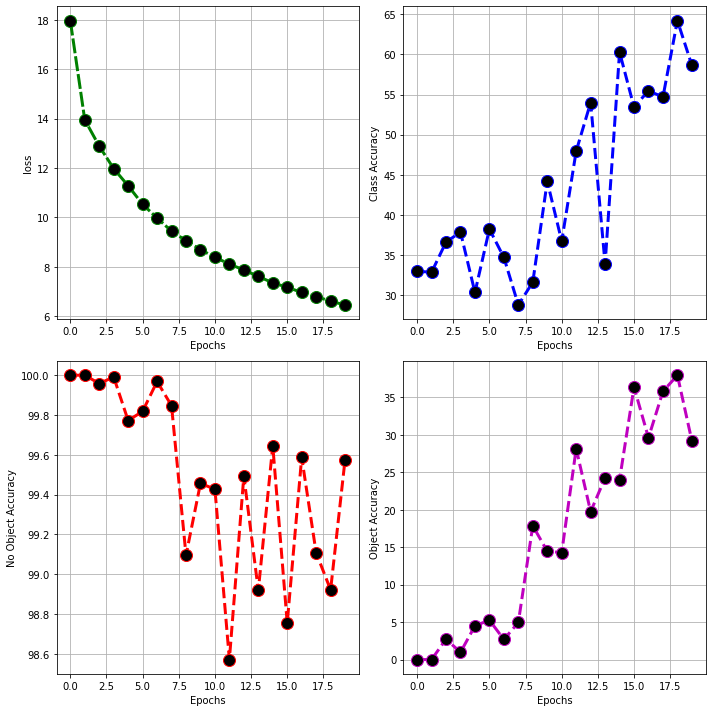

In [ ]:
import torch
model = YOLOV3(num_classes=NUM_CLASSES).to(DEVICE)

#optimizer1 = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
#optimizer2 = optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, momentum=0.9)
optimizer3 = optim.RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
#optimizer4 = optim.Adagrad(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

map_dict={}
Epoch_dict={}
loss_dict={}
class_accuracy_dict={}
noobj_accuracy_dict={}
obj_accuracy_dict={}

optimizer_list=[ optimizer3 ]
for different_optimizers in optimizer_list:
  map_list=[]
  Epoch_list=[]
  loss_list=[]
  class_accuracy_list=[]
  noobj_accuracy_list=[]
  obj_accuracy_list=[]
  optimizer = different_optimizers
  print('For optimizer:',optimizer)
  loss_fn = YoloLoss()
  scaler = torch.cuda.amp.GradScaler()

  train_csv_path='/content/drive/MyDrive/pascalvoc/train.csv'
  test_csv_path='/content/drive/My Drive/pascalvoc/test.csv'

  IMAGE_SIZE = IMAGE_SIZE

  train_dataset = YOLODataset(train_csv_path, transform=train_transforms, S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8], img_dir=IMG_DIR, label_dir=LABEL_DIR,anchors=ANCHORS)
  test_dataset = YOLODataset(test_csv_path, transform=test_transforms, S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8], img_dir=IMG_DIR, label_dir=LABEL_DIR,anchors=ANCHORS)

  train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

  if LOAD_MODEL:
    load_checkpoint(f'/content/drive/MyDrive/model.pt', model, optimizer, loss_fn, LEARNING_RATE)

  scaled_anchors = (torch.tensor(ANCHORS)*torch.tensor(S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)).to(DEVICE)

  for epoch in range(NUM_EPOCHS):
      print("Running epoch number:", epoch)
      current_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors)
      Epoch_list.append(epoch)
      loss_list.append(current_loss)
          
          
      if SAVE_MODEL:
          save_checkpoint(model, optimizer,loss_fn, filename=f'/content/drive/MyDrive/model.pt')

      CLASS, NOOBJECT, OBJECT = check_class_accuracy(model, train_loader, threshold=CONF_THRESHOLD)
      class_accuracy_list.append(CLASS)
      noobj_accuracy_list.append(NOOBJECT)
      obj_accuracy_list.append(OBJECT)

      if epoch > 0 and epoch % 5 == 0:
          print("On test Loader")
          check_class_accuracy(model, test_loader, threshold=CONF_THRESHOLD)
          pred_boxes, true_boxes = get_evaluation_bboxes(test_loader, model, iou_threshold=NMS_IOU_THRESH, anchors=ANCHORS, threshold=CONF_THRESHOLD,)
          mapval = mean_average_precision( pred_boxes, true_boxes, iou_threshold=MAP_IOU_THRESH, box_format="midpoint", num_classes=NUM_CLASSES,)
          map_list.append(mapval)
          print(f"MAP: {mapval.item()}")
          model.train()

  experiment_plots(Epoch_list, loss_list, class_accuracy_list, noobj_accuracy_list, obj_accuracy_list)
  Epoch_dict[optimizer]= Epoch_list
  loss_dict[optimizer]= loss_list
  class_accuracy_dict[optimizer]= class_accuracy_list
  noobj_accuracy_dict[optimizer]= noobj_accuracy_list
  obj_accuracy_dict[optimizer] = obj_accuracy_list
  map_dict[optimizer] = map_list
  


For optimizer: Adagrad (
Parameter Group 0
    eps: 1e-10
    foreach: None
    initial_accumulator_value: 0
    lr: 0.0003
    lr_decay: 0
    maximize: False
    weight_decay: 0
)
Running epoch number: 0


100%|██████████| 518/518 [2:13:33<00:00, 15.47s/it, loss=22.6]


=> Saving checkpoint


100%|██████████| 518/518 [06:40<00:00,  1.29it/s]


Class accuracy is: 32.752476%
No obj accuracy is: 99.735634%
Obj accuracy is: 0.030408%
Running epoch number: 1


100%|██████████| 518/518 [10:34<00:00,  1.22s/it, loss=16.8]


=> Saving checkpoint


100%|██████████| 518/518 [06:39<00:00,  1.30it/s]


Class accuracy is: 33.285145%
No obj accuracy is: 99.970184%
Obj accuracy is: 0.002536%
Running epoch number: 2


100%|██████████| 518/518 [10:34<00:00,  1.22s/it, loss=15.6]


=> Saving checkpoint


100%|██████████| 518/518 [06:39<00:00,  1.30it/s]


Class accuracy is: 33.474922%
No obj accuracy is: 99.999931%
Obj accuracy is: 0.000000%
Running epoch number: 3


100%|██████████| 518/518 [10:34<00:00,  1.22s/it, loss=14.8]


=> Saving checkpoint


100%|██████████| 518/518 [06:40<00:00,  1.29it/s]


Class accuracy is: 34.442417%
No obj accuracy is: 99.992493%
Obj accuracy is: 0.000845%
Running epoch number: 4


100%|██████████| 518/518 [10:34<00:00,  1.23s/it, loss=14.2]


=> Saving checkpoint


100%|██████████| 518/518 [06:38<00:00,  1.30it/s]


Class accuracy is: 34.958694%
No obj accuracy is: 99.999985%
Obj accuracy is: 0.000846%
Running epoch number: 5


100%|██████████| 518/518 [10:34<00:00,  1.23s/it, loss=13.7]


=> Saving checkpoint


100%|██████████| 518/518 [06:38<00:00,  1.30it/s]


Class accuracy is: 35.820770%
No obj accuracy is: 99.997238%
Obj accuracy is: 0.177674%
On test Loader


100%|██████████| 155/155 [1:52:00<00:00, 43.35s/it]


Class accuracy is: 41.609867%
No obj accuracy is: 99.998093%
Obj accuracy is: 0.163480%


100%|██████████| 155/155 [03:25<00:00,  1.33s/it]


MAP: 0.0003077337460126728
Running epoch number: 6


100%|██████████| 518/518 [10:34<00:00,  1.22s/it, loss=13.3]


=> Saving checkpoint


100%|██████████| 518/518 [06:40<00:00,  1.29it/s]


Class accuracy is: 36.480350%
No obj accuracy is: 99.998009%
Obj accuracy is: 0.071843%
Running epoch number: 7


100%|██████████| 518/518 [10:34<00:00,  1.23s/it, loss=13]


=> Saving checkpoint


100%|██████████| 518/518 [06:39<00:00,  1.30it/s]


Class accuracy is: 37.659870%
No obj accuracy is: 99.992195%
Obj accuracy is: 0.714280%
Running epoch number: 8


100%|██████████| 518/518 [10:33<00:00,  1.22s/it, loss=12.7]


=> Saving checkpoint


100%|██████████| 518/518 [06:37<00:00,  1.30it/s]


Class accuracy is: 37.815372%
No obj accuracy is: 99.986832%
Obj accuracy is: 1.150425%
Running epoch number: 9


100%|██████████| 518/518 [10:33<00:00,  1.22s/it, loss=12.5]


=> Saving checkpoint


100%|██████████| 518/518 [06:37<00:00,  1.30it/s]


Class accuracy is: 38.735264%
No obj accuracy is: 99.984627%
Obj accuracy is: 1.407141%
Running epoch number: 10


100%|██████████| 518/518 [10:33<00:00,  1.22s/it, loss=12.2]


=> Saving checkpoint


100%|██████████| 518/518 [06:38<00:00,  1.30it/s]


Class accuracy is: 39.272617%
No obj accuracy is: 99.989738%
Obj accuracy is: 0.865084%
On test Loader


100%|██████████| 155/155 [01:37<00:00,  1.58it/s]


Class accuracy is: 45.275700%
No obj accuracy is: 99.993660%
Obj accuracy is: 0.712109%


100%|██████████| 155/155 [03:29<00:00,  1.35s/it]


MAP: 0.004454866982996464
Running epoch number: 11


100%|██████████| 518/518 [10:32<00:00,  1.22s/it, loss=12.1]


=> Saving checkpoint


100%|██████████| 518/518 [06:38<00:00,  1.30it/s]


Class accuracy is: 39.871735%
No obj accuracy is: 99.984146%
Obj accuracy is: 1.482927%
Running epoch number: 12


100%|██████████| 518/518 [10:33<00:00,  1.22s/it, loss=11.9]


=> Saving checkpoint


100%|██████████| 518/518 [06:38<00:00,  1.30it/s]


Class accuracy is: 40.426163%
No obj accuracy is: 99.974808%
Obj accuracy is: 2.088546%
Running epoch number: 13


100%|██████████| 518/518 [10:33<00:00,  1.22s/it, loss=11.7]


=> Saving checkpoint


100%|██████████| 518/518 [06:38<00:00,  1.30it/s]


Class accuracy is: 40.884476%
No obj accuracy is: 99.972191%
Obj accuracy is: 2.186679%
Running epoch number: 14


100%|██████████| 518/518 [10:32<00:00,  1.22s/it, loss=11.6]


=> Saving checkpoint


100%|██████████| 518/518 [06:38<00:00,  1.30it/s]


Class accuracy is: 41.417469%
No obj accuracy is: 99.955322%
Obj accuracy is: 3.086717%
Running epoch number: 15


100%|██████████| 518/518 [10:32<00:00,  1.22s/it, loss=11.4]


=> Saving checkpoint


100%|██████████| 518/518 [06:38<00:00,  1.30it/s]


Class accuracy is: 42.119087%
No obj accuracy is: 99.950623%
Obj accuracy is: 3.699575%
On test Loader


100%|██████████| 155/155 [01:37<00:00,  1.58it/s]


Class accuracy is: 47.359379%
No obj accuracy is: 99.969330%
Obj accuracy is: 2.568578%


100%|██████████| 155/155 [03:32<00:00,  1.37s/it]


MAP: 0.013647566549479961
Running epoch number: 16


100%|██████████| 518/518 [10:33<00:00,  1.22s/it, loss=11.3]


=> Saving checkpoint


100%|██████████| 518/518 [06:38<00:00,  1.30it/s]


Class accuracy is: 42.719875%
No obj accuracy is: 99.944649%
Obj accuracy is: 3.721827%
Running epoch number: 17


100%|██████████| 518/518 [10:33<00:00,  1.22s/it, loss=11.1]


=> Saving checkpoint


100%|██████████| 518/518 [06:37<00:00,  1.30it/s]


Class accuracy is: 42.901203%
No obj accuracy is: 99.950661%
Obj accuracy is: 3.265058%
Running epoch number: 18


100%|██████████| 518/518 [10:33<00:00,  1.22s/it, loss=11]


=> Saving checkpoint


100%|██████████| 518/518 [06:37<00:00,  1.30it/s]


Class accuracy is: 43.373180%
No obj accuracy is: 99.882957%
Obj accuracy is: 5.171700%
Running epoch number: 19


100%|██████████| 518/518 [10:33<00:00,  1.22s/it, loss=10.9]


=> Saving checkpoint


100%|██████████| 518/518 [06:38<00:00,  1.30it/s]


Class accuracy is: 44.375141%
No obj accuracy is: 99.905998%
Obj accuracy is: 4.826619%


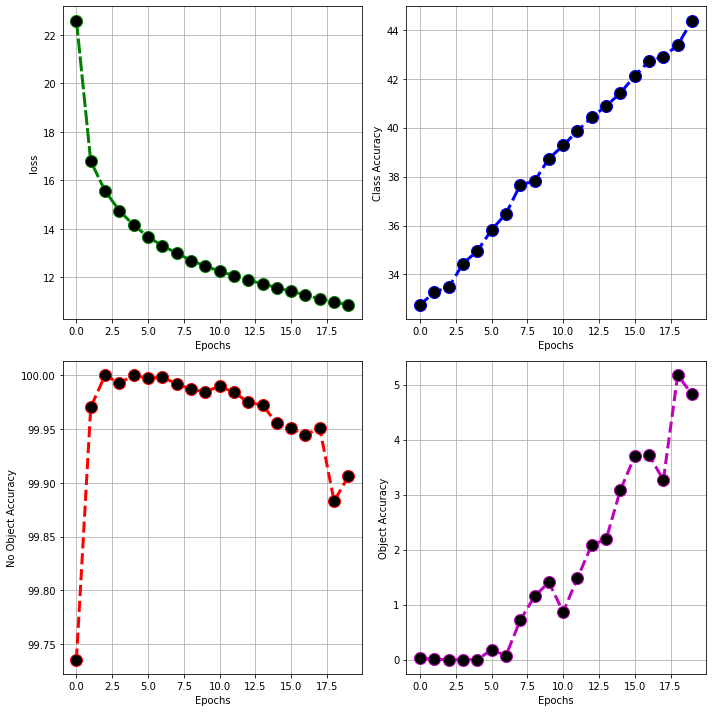

In [ ]:
import torch
model = YOLOV3(num_classes=NUM_CLASSES).to(DEVICE)

#optimizer1 = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
#optimizer2 = optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, momentum=0.9)
#optimizer3 = optim.RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
optimizer4 = optim.Adagrad(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

map_dict={}
Epoch_dict={}
loss_dict={}
class_accuracy_dict={}
noobj_accuracy_dict={}
obj_accuracy_dict={}

optimizer_list=[ optimizer4 ]
for different_optimizers in optimizer_list:
  map_list=[]
  Epoch_list=[]
  loss_list=[]
  class_accuracy_list=[]
  noobj_accuracy_list=[]
  obj_accuracy_list=[]
  optimizer = different_optimizers
  print('For optimizer:',optimizer)
  loss_fn = YoloLoss()
  scaler = torch.cuda.amp.GradScaler()

  train_csv_path='/content/drive/MyDrive/pascalvoc/train.csv'
  test_csv_path='/content/drive/My Drive/pascalvoc/test.csv'

  IMAGE_SIZE = IMAGE_SIZE

  train_dataset = YOLODataset(train_csv_path, transform=train_transforms, S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8], img_dir=IMG_DIR, label_dir=LABEL_DIR,anchors=ANCHORS)
  test_dataset = YOLODataset(test_csv_path, transform=test_transforms, S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8], img_dir=IMG_DIR, label_dir=LABEL_DIR,anchors=ANCHORS)

  train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

  if LOAD_MODEL:
    load_checkpoint(f'/content/drive/MyDrive/model.pt', model, optimizer, loss_fn, LEARNING_RATE)

  scaled_anchors = (torch.tensor(ANCHORS)*torch.tensor(S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)).to(DEVICE)

  for epoch in range(NUM_EPOCHS):
      print("Running epoch number:", epoch)
      current_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors)
      Epoch_list.append(epoch)
      loss_list.append(current_loss)
          
          
      if SAVE_MODEL:
          save_checkpoint(model, optimizer,loss_fn, filename=f'/content/drive/MyDrive/model.pt')

      CLASS, NOOBJECT, OBJECT = check_class_accuracy(model, train_loader, threshold=CONF_THRESHOLD)
      class_accuracy_list.append(CLASS)
      noobj_accuracy_list.append(NOOBJECT)
      obj_accuracy_list.append(OBJECT)

      if epoch > 0 and epoch % 5 == 0:
          print("On test Loader")
          check_class_accuracy(model, test_loader, threshold=CONF_THRESHOLD)
          pred_boxes, true_boxes = get_evaluation_bboxes(test_loader, model, iou_threshold=NMS_IOU_THRESH, anchors=ANCHORS, threshold=CONF_THRESHOLD,)
          mapval = mean_average_precision( pred_boxes, true_boxes, iou_threshold=MAP_IOU_THRESH, box_format="midpoint", num_classes=NUM_CLASSES,)
          map_list.append(mapval)
          print(f"MAP: {mapval.item()}")
          model.train()

  experiment_plots(Epoch_list, loss_list, class_accuracy_list, noobj_accuracy_list, obj_accuracy_list)
  Epoch_dict[optimizer]= Epoch_list
  loss_dict[optimizer]= loss_list
  class_accuracy_dict[optimizer]= class_accuracy_list
  noobj_accuracy_dict[optimizer]= noobj_accuracy_list
  obj_accuracy_dict[optimizer] = obj_accuracy_list
  map_dict[optimizer] = map_list
  
